In [1]:
from tqdm import tqdm
import numpy as np
from scipy.optimize import minimize
from scipy.special import softmax, log_softmax
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns

In [2]:
n = 10_000
z = np.random.choice([0, 1, 2], size=n, p=[0.2, 0.3, 0.5])
x = np.random.normal(loc=[0, 5, -3], scale=[1, 2, 0.5], size=(n, 3))[range(n), z]

<AxesSubplot:ylabel='Count'>

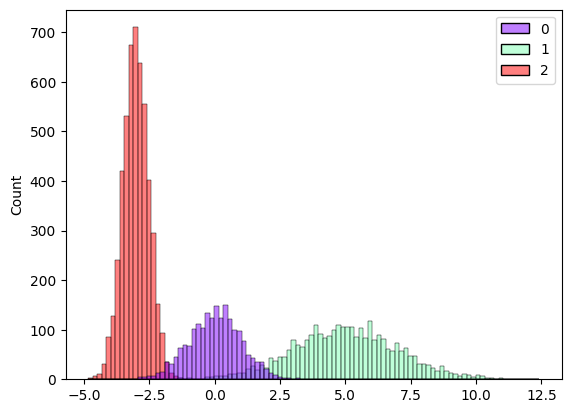

In [3]:
sns.histplot(x=x, hue=z, bins=100, palette='rainbow')

<AxesSubplot:ylabel='Count'>

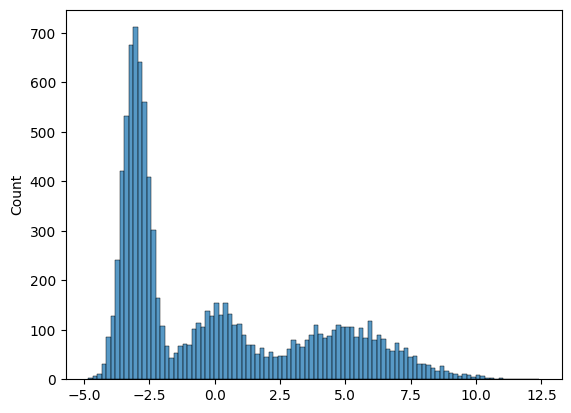

In [4]:
sns.histplot(x=x, bins=100)

In [5]:
def gaussian_pdf(x, mu, sigma):
    return np.exp(-(x[:, None] - mu) ** 2 / (2 * sigma ** 2)) / np.sqrt(2 * np.pi * sigma ** 2)


def log_gaussian_pdf(x, mu, sigma):
    return -(x[:, None] - mu) ** 2 / (2 * sigma ** 2) - np.log(2 * np.pi * sigma ** 2) / 2


def e_step(x, theta):
    mu, sigma, p = theta[:3], theta[3:6], softmax(theta[6:])
    q = gaussian_pdf(x, mu, sigma) * p
    q /= q.sum(axis=1, keepdims=True)
    return q


def m_step(x, q, theta_init):
    def obj(theta):
        mu, sigma, log_p = theta[:3], theta[3:6], theta[6:]
        return -np.sum(q * (log_gaussian_pdf(x, mu, sigma) + log_softmax(log_p)))

    res = minimize(obj, theta_init)
    return res.x

In [6]:
# initial guess
mu = np.random.normal(scale=0.2, size=3)
sigma = np.array([1, 1, 1])
log_p = np.array([0, 0, 0])
theta = np.concatenate((mu, sigma, log_p))
thetas = [theta]

n_iter = 100

for i in tqdm(range(n_iter)):
    q = e_step(x, theta)
    theta = m_step(x, q, theta)
    if np.abs(np.max(theta - thetas[-1])) < 1e-3:
        break

    thetas.append(theta)

 43%|███    | 43/100 [00:15<00:20,  2.76it/s]


<IPython.core.display.Javascript object>


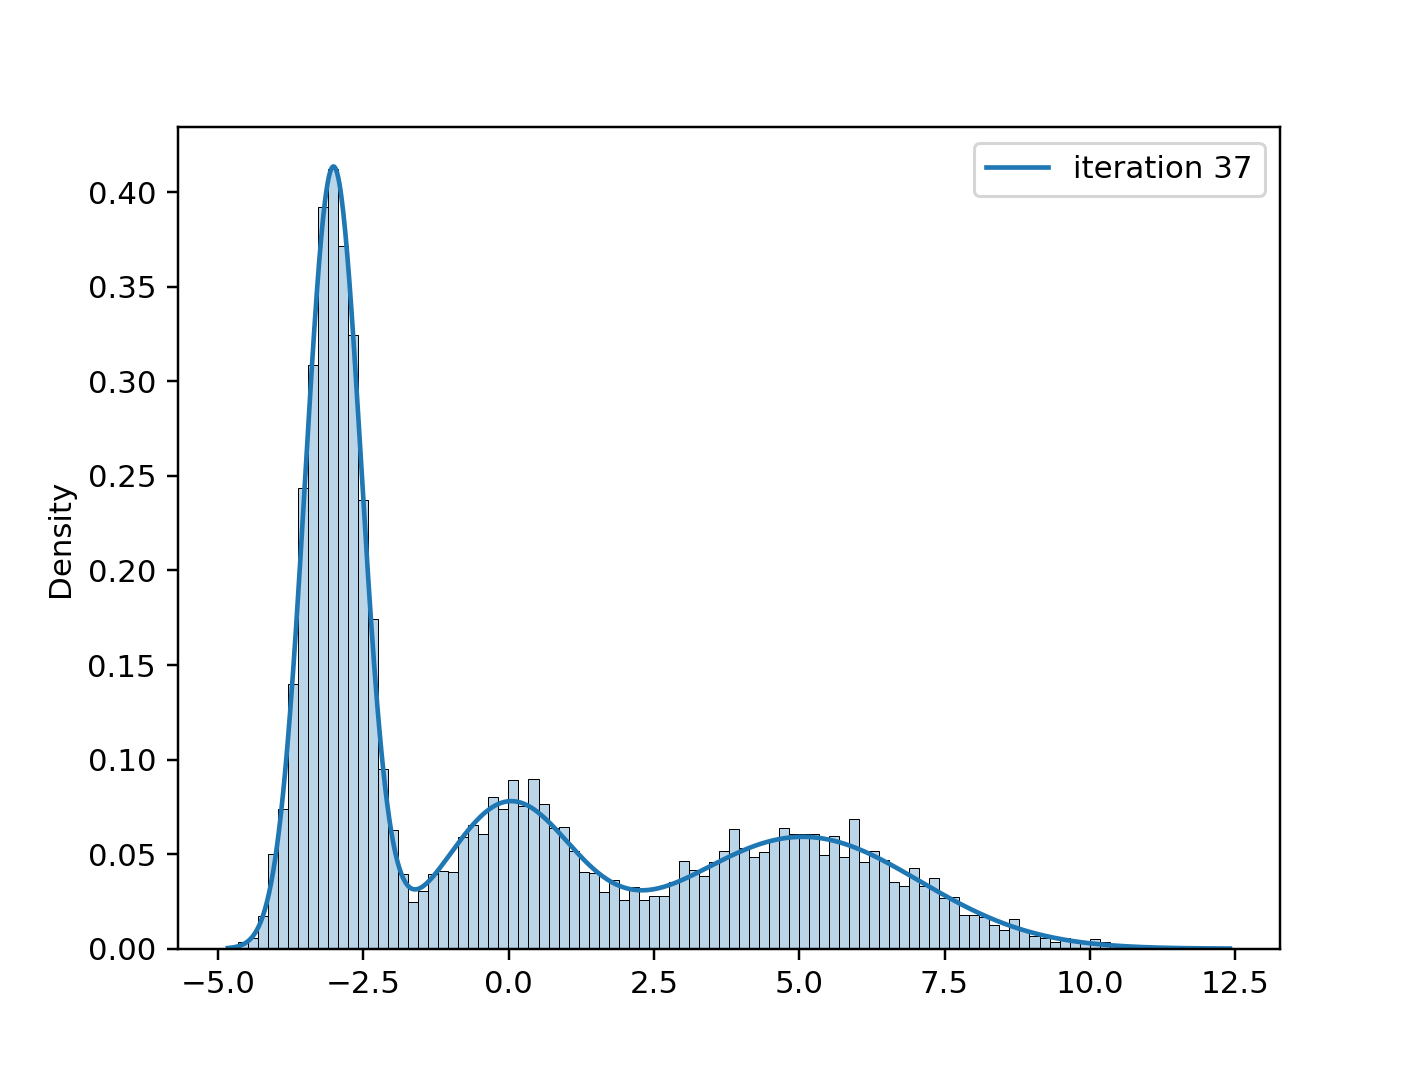

In [7]:
%matplotlib notebook

fig = plt.figure()

def animate(i):
    theta = thetas[i]
    mu, sigma, log_p = theta[:3], theta[3:6], theta[6:]
    p = softmax(log_p)
    xs = np.linspace(x.min(), x.max(), 1000)
    pdf = np.sum(gaussian_pdf(xs, mu, sigma) * p, axis=1)
    plt.clf()
    sns.histplot(x=x, bins=100, stat='density', alpha=0.3)
    plt.plot(xs, pdf, label=f'iteration {i}')
    plt.legend()


ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(len(thetas)), repeat=True)